# Two-qubit Transverse field Ising model by quantum approximate optimization algorithm



<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
nonlinearxwaves@gmail.com<br>


@created 7 sep 2022<br>
@version 7 sep 2022

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
from thqml import quantummap as quantummap
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

# Define Hamiltonian operator

$\hat{\mathcal{H}}=-J Z_0 Z_1 -h_0 X_0 -h_1 X_1$

In [3]:
@tf.function
def Hamiltonian(J=1, h=[0,0]):
    """ Two-qubit tranverse Ising model Hamiltonian
    
        H=-J Z0 Z1 -h0 X0 -h1 X0
        
        Params
        ------
        J = coupling shape=(1,)
        h = field shape=(2,)
    """
    out = -J*quantummap.ZZ-h[0]*quantummap.XI-h[1]*quantummap.IX
        
    return out

## Test the Hamiltonian

Hamiltonian with no field terms

In [4]:
H=Hamiltonian()
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


Hamiltonian with field terms

In [5]:
H=Hamiltonian(h=[1.1,3.2])
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1. +0.j -3.2+0.j -1.1+0.j -0. +0.j]
 [-3.2+0.j  1. -0.j -0. +0.j -1.1+0.j]
 [-1.1+0.j -0. +0.j  1. -0.j -3.2+0.j]
 [-0. +0.j -1.1+0.j -3.2+0.j -1. +0.j]], shape=(4, 4), dtype=complex64)


## Find eigenvalues an eigenvectors of H

Let us consider the Hamiltonian with no field

In [6]:
H=Hamiltonian()

Transforms H into a 4x4 numpy matrix

In [7]:
Hmatrix=quantummap.Transform2Matrix(H).numpy()

In [8]:
print(Hmatrix)

[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]]


Eigenvalues of H

In [9]:
eigenvalues, eigenvectors=np.linalg.eig(Hmatrix)

In [10]:
print(eigenvalues)

[-1.+0.j  1.-0.j  1.-0.j -1.+0.j]


In [11]:
print(eigenvectors)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


So the ground state is doubly degenerate with eigenvalue -1

Eigenvalues $-1$ are <code>eigenvalues[0]</code> and <code>eigenvalues[3]</code>

The two corresponding eigevectos are $|00\rangle=|\downarrow\downarrow\rangle$ and $|11\rangle=|\uparrow\uparrow\rangle$,

which correspond to parallel spins and <code>eigenvectors[:,0]</code> and <code>eigenvectors[:,3]</code> 

In [12]:
print(eigenvalues[0])
print(eigenvectors[:,0])

(-1+0j)
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [13]:
print(eigenvalues[3])
print(eigenvectors[:,3])

(-1+0j)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


# Variational Ansatz with Two Qubit, first version, non entangled map

## Number of parameters in the variational ansatz

In [14]:
ntheta=6

In [15]:
nlayer=2
theta=np.random.random(2*nlayer)
print(theta)
gamma=theta[:nlayer]
beta=theta[nlayer:]
print(gamma)
print(beta)
print(gamma[0])

[0.19 0.79 0.49 0.08]
[0.19 0.79]
[0.49 0.08]
0.19271706771161


## A simple variational ansatz with rotations

In [16]:
@tf.function
def QAOA(theta, phi, layers=1, J=1, h=[0.0,0.0]):
    """ Feature Map for the 
    Quantum Approximate Optimization Algorithm
    
    Params
    ------
    theta, shape=(2*layers,) real parameters 
    phi,   two-qubit state
    layers=1, number of iterations
    
    Returns
    -------
    A two-qubit state
    """
    h0=h[0]
    h1=h[1]
    
    # extract parameters of the layers
    gamma=theta[:layers]
    beta=theta[layers:]

    # init the state as H|00>
    phi=quantummap.Gate(quantummap.HH,phi)
    # function for a step
    def UC(phi, gamma, beta):
        # e^{i gamma C}
        C=quantummap.EZZ(-J*gamma)
        phi=quantummap.Gate(C,phi)
        C=quantummap.EXI(-h0*gamma)
        phi=quantummap.Gate(C,phi)
        C=quantummap.EXI(-h1*gamma)
        phi=quantummap.Gate(C,phi)        
        # e^{i beta B}
        phi=quantummap.Gate(quantummap.EXI(beta),phi)
        phi=quantummap.Gate(quantummap.EIX(beta),phi)
        return phi

    # iterate the layers
    for  j in range(layers):
        phi=UC(phi, gamma[j], beta[j])
        
    return phi

# Layer with weights theta and output mean Hamiltonian

In [17]:
class HamiltonianLayerQAOA(tf.keras.layers.Layer):
    # Define a Layer returning the mean value of the Hamiltonian
    # with
    # Quantum Approximate Optimization Annealing
    #
    # The layer has trainable parameters, i.e.,
    # the  parameters theta of the trainable feature map
    #
    # The Layer use the functions
    # Hamiltonian
    # QAOA 
    #
    # The constructor use parameters 
    #
    #  Params
    #  ------
    #  J : coupling coefficient
    #      (default J=1)
    #  h : positive field shape=(2,)
    #      (default h=[0.0,0.0])
    #  map: a function containing the feature map
    #      (default is QAOA)
    #  pQAOA: iterations of the QAOA feature map
    #      (default is 1)
    #  bias: the bias state
    #      (default is ground state quantummap.q00)
    #
    #  Example
    #  -------
    #  HL=HL(J=.5, h=[1.2,-1.0],pQAOA=3)
    #
    #  Returns
    #  -------
    #  The call return the real part of 
    #  <\psi|H|\psi>
    #
    def __init__(self, J=1.0, h=[0.0,0.0], 
                 FeatureMap=QAOA, 
                 pQAOA=1,
                 q00=quantummap.q00,
                 **kwargs):
        super(HamiltonianLayerQAOA, self).__init__(**kwargs)
        # trainable parameter of the model
        # initially set as random (real variables)
        self.theta=tf.Variable(np.random.random(2*pQAOA),
                               dtype=tf.float32,
                              name='theta')
        # gap coefficient
        self.J=J
        # field coefficient
        self.h=h
        # Hamiltonian
        self.H=Hamiltonian(J=self.J,h=self.h)
        # Bias state
        self.q00=q00
        # Feature map for the ground state
        self.FeatureMap=FeatureMap
        # Number of layers of QAOA
        self.pQAOA=pQAOA
    def ground_state(self):
        """ Return the current ground state """
        phi=self.FeatureMap(self.theta,self.q00,self.pQAOA, self.J,self.h)
        return phi
    def call(self,dummy):
        """ Return Re<H> 
        Remark:  this layer has a dummy variable as input
        (required for compatibility with tensorflow call)
        """
        phi=self.ground_state()
        Hphi=quantummap.Gate2(self.H,phi)
        meanH=quantummap.Scalar(phi, Hphi)
        return tf.math.real(meanH)

## Test the layer

Create the layer with default parameters

In [18]:
HL=HamiltonianLayerQAOA()

Print J and H

In [19]:
print(HL.J, HL.h)

1.0 ListWrapper([0.0, 0.0])


Display $\mathcal{\hat{H}}$ as a matrix

In [20]:
print(quantummap.Transform2Matrix(HL.H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


Display the current ground state

In [21]:
print(HL.ground_state())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tf.Tensor(
[[-0.47+0.42j  0.28+0.17j]
 [ 0.28+0.17j -0.47+0.42j]], shape=(2, 2), dtype=complex64)


Display the current weights

In [22]:
print(HL.weights)

[<tf.Variable 'theta:0' shape=(2,) dtype=float32, numpy=array([0.91, 0.94], dtype=float32)>]


Compute $\mathcal{\hat{H}}|\phi\rangle$

In [23]:
Hphi=quantummap.Gate2(HL.H,HL.ground_state())

Compute $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [24]:
quantummap.Scalar2(HL.ground_state(),Hphi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[-0.57+0.j]], dtype=complex64)>

Call the layer and check is equal to $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [25]:
HL(1.0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.57]], dtype=float32)>

note the input to the layer is a dummy real number

# Define and train the model

In [26]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin1 = tf.keras.layers.Input(1,name='DummyInput1');
# Hamiltonianl layer
HL1=HamiltonianLayerQAOA(J=J,h=h, pQAOA=3, name='H1')
# output
meanH1=HL1(xin1)
# trainable model returning meanH
Ising1 = tf.keras.Model(inputs = xin1, outputs=meanH1, name='model1')
# add loss function
Ising1.add_loss(meanH1)

## Test the model with dummy input

In [27]:
tf.print(Ising1(1.1))

[[1.37835336]]


# Summary of the model

In [28]:
Ising1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DummyInput1 (InputLayer)    [(None, 1)]               0         
                                                                 
 H1 (HamiltonianLayerQAOA)   (1, 1)                    6         
                                                                 
 add_loss (AddLoss)          (1, 1)                    0         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


## Plot model

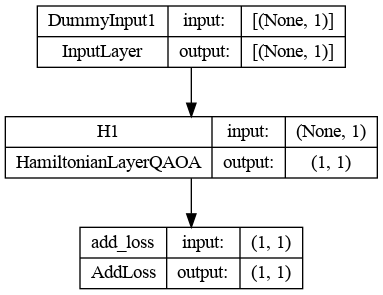

In [29]:
from keras.utils.vis_utils import plot_model
# save as pdf
plot_model(Ising1, to_file='TwoQubitIsingQAOA_plot.pdf', show_shapes=True, show_layer_names=True)
# save and display as png
plot_model(Ising1, to_file='TwoQubitIsingQAOA_plot.png', show_shapes=True, show_layer_names=True)

## Store the ground state before training

In [30]:
ground_state_0=tf.identity(HL.ground_state())
print(ground_state_0)

tf.Tensor(
[[-0.47+0.42j  0.28+0.17j]
 [ 0.28+0.17j -0.47+0.42j]], shape=(2, 2), dtype=complex64)


## Store the weights before training

In [31]:
weight0=tf.identity(Ising1.weights)
print(weight0)

tf.Tensor([[0.93 0.01 0.91 0.98 0.19 0.52]], shape=(1, 6), dtype=float32)


In [32]:
## Eigenvalues of the Hamiltonian

In [33]:
es=tf.linalg.eig(quantummap.Transform2Matrix(HL1.H))
print(es[0])
# find the lowest eigenvalue
esmin=np.min(tf.math.real(es[0].numpy()))
print("Lowest eigenvalues "+repr(esmin))

tf.Tensor([ 1.  +0.j -1.  +0.j -2.24+0.j  2.24+0.j], shape=(4,), dtype=complex64)
Lowest eigenvalues -2.2360685


# Train

In [34]:
Ising1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history1 = Ising1.fit(x=np.zeros(10,),epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 1s 665ms/step - loss: 1.3784
Epoch 2/200
1/1 [==============================] - 0s 4ms/step - loss: 1.0137
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 0.6060
Epoch 4/200
1/1 [==============================] - 0s 4ms/step - loss: 0.1711
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: -0.2734
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: -0.7083
Epoch 7/200
1/1 [==============================] - 0s 4ms/step - loss: -1.1140
Epoch 8/200
1/1 [==============================] - 0s 4ms/step - loss: -1.4718
Epoch 9/200
1/1 [==============================] - 0s 4ms/step - loss: -1.7657
Epoch 10/200
1/1 [==============================] - 0s 5ms/step - loss: -1.9846
Epoch 11/200
1/1 [==============================] - 0s 5ms/step - loss: -2.1244
Epoch 12/200
1/1 [==============================] - 0s 4ms/step - loss: -2.1892
Epoch 13/200
1/1 [==============================] -

In [35]:
Ising1.weights

[<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=array([ 0.82, -0.1 ,  0.97,  1.12,  0.32,  0.41], dtype=float32)>]

Plot the training history

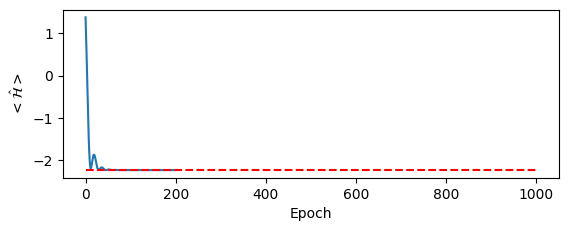

In [44]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history1.history['loss'])
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
# superimpose the lowest eigenvalue
xline=np.linspace(0,1000,100);
yline=esmin*np.ones_like(xline);
plt.plot(xline,yline,'r--')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsingQAOA.pdf", format="pdf", bbox_inches="tight")

Final value for the mean Hamiltonian

In [37]:
print('Final loss' +repr(history1.history['loss'][-1]))
print('Target energy' +repr(esmin))

Final loss-2.236067533493042
Target energy-2.2360685


Ground state computed from the feature map function with the trained weights and bias

In [38]:
phi=HL1.ground_state()
print(phi)

tf.Tensor(
[[0.56+0.23j 0.34+0.14j]
 [0.34+0.14j 0.56+0.23j]], shape=(2, 2), dtype=complex64)


Check if the ground state is normalized

In [39]:
quantummap.Scalar(phi,phi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

Ground state from the Hamiltonian layer (must be the same as above)

In [40]:
print(HL1.ground_state())

tf.Tensor(
[[0.56+0.23j 0.34+0.14j]
 [0.34+0.14j 0.56+0.23j]], shape=(2, 2), dtype=complex64)


Check the normalizzation

Parameters theta

In [41]:
HL1.theta

<tf.Variable 'theta:0' shape=(6,) dtype=float32, numpy=array([ 0.82, -0.1 ,  0.97,  1.12,  0.32,  0.41], dtype=float32)>

### Entanglement entropy of ground state

In [42]:
quantummap.VonNeumannEntropy2(HL1.ground_state())

(<tf.Tensor: shape=(), dtype=float32, numpy=0.29813445>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.95, 0.05], dtype=float32)>)

# Stop execution here, useful command for experiments follows

In [43]:
assert False # this stop execution

AssertionError: 

## Define a new model with $h_0=h$ and $h_1=0$

In [ ]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,0.0]
# Input layer (one dummy input)
xin2 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL2=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU1, name='H2')
# output
meanH2=HL2(xin2)
# trainable model returning meanH
Ising2 = tf.keras.Model(inputs = xin2, outputs=meanH2, name='model2')
# add loss function
Ising2.add_loss(meanH2)

### Compile and train

In [ ]:
# initialize tqdm callback with default parameters
Ising2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history2 = Ising2.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])
# Plot training & validation accuracy values
f2 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history2.history['loss'])
xline=np.linspace(0,1000,100);
yline=-np.sqrt(2.0)*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
#plt. savefig("trainingTwoQuibtModelIsing2.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history2.history['loss'][-1]))

### Print ground state

In [ ]:
print(HL2.ground_state())

### Check the entropy of the ground state

In [ ]:
quantummap.VonNeumannEntropy2(HL2.ground_state())

### Compute eigenvalue of H for check

In [ ]:
tf.linalg.eig(quantummap.Transform2Matrix(HL2.H))

## Define and train a model with $h_0=h_1=h$

### model definition

In [ ]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin3 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL3=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU1, name='H3')
# output
meanH3=HL3(xin3)
# trainable model returning meanH
Ising3 = tf.keras.Model(inputs = xin3, outputs=meanH3, name='model3')
# add loss function
Ising3.add_loss(meanH3)

### eigenvalues

In [ ]:
e3=tf.linalg.eig(quantummap.Transform2Matrix(HL3.H))
print(e3[0])
# find the lowest eigenvalue
e3min=np.min(tf.math.real(e3[0].numpy()))
print("Lowest eigenvalues "+repr(e3min))

### Compile and train

In [ ]:
# initialize tqdm callback with default parameters
Ising3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history3 = Ising3.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])
# Plot training & validation accuracy values
f3 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history3.history['loss'])
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing3.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history3.history['loss'][-1]))

### Ground state and its entropy

In [ ]:
print(HL3.ground_state())

In [ ]:
quantummap.VonNeumannEntropy2(HL3.ground_state())

### Eigenvalues

In [ ]:
tf.linalg.eig(quantummap.Transform2Matrix(HL3.H))

**Remark** in this case the model cannot find the low energy state, as this is entangled, and the feature map we are using does not have entanglement

Thus we have to consider a different feature map with entanglement

# Define an entangled feature map by a CZ gate

In [ ]:
@tf.function
def FeatureMapU2(theta, psi):
    """ Feature Map for the 
    Variational Quantum Algorithm
    with entanglement
    Obtained by FeatureMapU1
    with an additional CZ gate
    
    Params
    ------
    theta, shape=(6,) real 
    psi,   two-qubit state
    
    Returns
    -------
    A two-qubit state
    """
    phi=FeatureMapU1(theta,psi)
    # add an CZ gate that generates entanglement
    phi=quantummap.Gate(quantummap.CZ,phi)
    return phi

### Test the FeatureMapU2 with random weights

In [ ]:
# generate random weights
theta_test=np.random.random(6)
print("Weights theta_test "+repr(theta_test))
# generate a state with bias q00
phi_test=FeatureMapU2(theta_test,quantummap.q00)
print(phi_test)

### Check if the new state is entangled

In [ ]:
print("Entropy "+repr(quantummap.VonNeumannEntropy2(phi_test)[0]))
print("Probabilities "+repr(quantummap.VonNeumannEntropy2(phi_test)[1]))

<code>quantumap.VonNeumannEntropy2</code> return a list of two elements
entropy is the element [0]
the second output [1] are the probabilities in the density matrix

## Define the model with the new feature map

In [ ]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin4 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL4=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU2, name='H4')
# output
meanH4=HL4(xin4)
# trainable model returning meanH
Ising4 = tf.keras.Model(inputs = xin4, outputs=meanH4, name='model4')
# add loss function
Ising4.add_loss(meanH4)

In [ ]:
# initialize tqdm callback with default parameters
Ising4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history4 = Ising4.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])
# Plot training & validation accuracy values
f4 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history4.history['loss'])
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing4.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history4.history['loss'][-1]))

In [ ]:
quantummap.VonNeumannEntropy2(HL4.ground_state())

## Define a model with iterated entangled feature map

In [ ]:
@tf.function
def FeatureMapU3(theta, psi):
    # Define a new feature map 
    # with entanglement
    # by iterating the FeatureMapU2
    psi = FeatureMapU2(theta, psi)
    psi = FeatureMapU2(theta, psi)
    return psi

### Test the iterated map 

In [ ]:
# generate a state with bias q00
phi_test2=FeatureMapU3(theta_test,quantummap.q00)
print(phi_test2)
print("Entropy "+repr(quantummap.VonNeumannEntropy2(phi_test2)))

**Remark** the iterated feature map as higher entropy

In [ ]:
print(theta_test)

## Define the model with the new feature map

In [ ]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin5 = tf.keras.layers.Input(1);
# Hamiltonian layer
HL5=HamiltonianLayer(J=J,h=h, nparams=6,FeatureMap=FeatureMapU3, name='H5')
# output
meanH5=HL5(xin5)
# trainable model returning meanH
Ising5 = tf.keras.Model(inputs = xin5, outputs=meanH5, name='model5')
# add loss function
Ising5.add_loss(meanH5)

In [ ]:
# initialize tqdm callback with default parameters
Ising5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
history5 = Ising5.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])
# Plot training & validation accuracy values
f5 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history5.history['loss'])
xline=np.linspace(0,1000,100);
yline=e3min*np.ones_like(xline);
plt.plot(xline,yline,'r--')
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingTwoQuibtModelIsing5.pdf", format="pdf", bbox_inches="tight")
#print last value of Hamiltonian
print("Last value of loss "+repr(history5.history['loss'][-1]))

In [ ]:
quantummap.VonNeumannEntropy2(HL5.ground_state())

Exit the notebook

In [ ]:
assert False

## Iterated Feature Map

In [ ]:
@tf.function
def FeatureMapU1U1(theta, psi):
    psi = FeatureMapU1(theta, psi)
    psi = FeatureMapU1(theta, psi)
    psi = FeatureMapU1(theta, psi)
    return psi

Test the feature map

In [ ]:
Upsi=FeatureMapU1(tf.constant(np.random.random(ntheta)),quantummap.q00)
print(Upsi)

# TODO check the entanglement of the ground state 

# Variational Ansatz with Two Qubit, first version

In [ ]:
@tf.function
def FeatureMapU(theta, psi):
    thetaX0=theta[0]
    thetaX1=theta[1]
    thetaZZ=theta[2]
    thetaY0=theta[3]
    thetaY1=theta[4]
    thetaZ0=theta[5]
    thetaZ1=theta[6]    
    psi=quantummap.Gate(quantummap.HH,psi)
    psi=quantummap.Gate(quantummap.EXI(thetaX0),psi)
    psi=quantummap.Gate(quantummap.EIX(thetaX1),psi)
    psi=quantummap.Gate(quantummap.EZZ(thetaZZ),psi)
    psi=quantummap.Gate(quantummap.EYI(thetaY0),psi)
    psi=quantummap.Gate(quantummap.EIY(thetaY1),psi)
    psi=quantummap.Gate(quantummap.EZZ(thetaZZ),psi)
    psi=quantummap.Gate(quantummap.EZI(thetaZ0),psi)
    psi=quantummap.Gate(quantummap.EIZ(thetaZ1),psi)
    psi=quantummap.Gate(quantummap.EZZ(thetaZZ),psi)
    return psi

## Iterated Feature Map

In [ ]:
@tf.function
def FeatureMapUU(theta, psi):
    psi = FeatureMapU(theta, psi)
    psi = FeatureMapU(theta, psi)
    psi = FeatureMapU(theta, psi)
    return psi

Test the feature map

In [ ]:
Upsi=FeatureMapU(tf.constant(np.random.random(ntheta)),quantummap.q00)
print(Upsi)

# Layer with weights theta and output mean Hamiltonian

In [ ]:
class HamiltonianLayer(tf.keras.layers.Layer):
    # Define a Layer returning the mean value of the Hamiltonian
    # on the variational ansatz
    #
    # The layer has a trainable parameters the 
    # parameters theta of the trainable feature map
    # theta[0] as theta_x
    # theta[1] as theta_y
    # theta[2] as theta_z
    #
    # The Layer use the functions
    # Hamiltonian
    # FeatureMapU
    #
    # The constructor use parameters 
    #
    #  Params
    #  ------
    #  J : coupling coefficient
    #  h : positive field shape=(2,)
    #
    #  Example
    #  -------
    #  HL=HL(J=.5, h=[1.2,-1.0])
    #
    #  The call return the real part of 
    #  <\psi|H\psi>
    #
    def __init__(self, J=1.0, h=[0.0,0.0], **kwargs):
        super(HamiltonianLayer, self).__init__(**kwargs)
        # trainable parameter of the model
        # initially set as random (real variables)
        self.theta=tf.Variable(np.random.random(ntheta),
                               dtype=tf.float32,
                              name='theta')
        # gap coefficient
        self.J=J
        # field coefficient
        self.h=h
        # Hamiltonian
        self.H=Hamiltonian(J=self.J,h=self.h)
        # Feature map for the ground state
        self.FeatureMap=FeatureMapUU
    def ground_state(self):
        """ Return the current ground state """
        psi=self.FeatureMap(self.theta,quantummap.q00)
        return psi
    def call(self,dummy):
        """ Return Re<H> 
        Remark:  this layer has a dummy variable as input
        (required for compatibility with tensorflow call)
        """
        #psi=self.FeatureMap(self.theta,quantummap.qubit0)
        psi=self.ground_state()
        meanH=quantummap.Scalar(psi, 
                                quantummap.Gate2(self.H, psi))
        return tf.math.real(meanH)

## Test the layer

In [ ]:
HL=HamiltonianLayer(name="Hamiltonian")

In [ ]:
print(HL.J, HL.h)

In [ ]:
print(quantummap.Transform2Matrix(HL.H))

In [ ]:
print(HL.ground_state())

In [ ]:
print(HL.weights)

In [ ]:
quantummap.Gate2(HL.H,HL.ground_state())

In [ ]:
quantummap.Scalar2(HL.ground_state(),HL.ground_state())

In [ ]:
quantummap.Scalar2(HL.ground_state(),quantummap.Gate2(HL.H,HL.ground_state()))

In [ ]:
quantummap.Scalar(quantummap.q11,quantummap.Gate2(HL.H,quantummap.q11))

In [ ]:
quantummap.Scalar(quantummap.q01,quantummap.Gate2(HL.H,quantummap.q01))

# Define and train the model

In [ ]:
# hyperparameter for the Hamiltonain
J=1.0
h=[1.0, 1.0]
# Input layer (one dummy input)
xin = tf.keras.layers.Input(1);
# Hamiltonianl layer
HL=HamiltonianLayer(J=J,h=h)
# output
meanH=HL(xin)
# trainable model returning meanH
Ising = tf.keras.Model(inputs = xin, outputs=meanH)

## Test the model with dummy input

In [ ]:
tf.print(Ising(1.1))

# Add loss function

In [ ]:
# add loss function
#Ising.add_loss(tf.math.exp(meanH))
Ising.add_loss(meanH)

# Summary of the model

In [ ]:
Ising.summary()

## Plot model

In [ ]:
from keras.utils.vis_utils import plot_model
# save as pdf
plot_model(Ising, to_file='TwoQubitIsing_plot.pdf', show_shapes=True, show_layer_names=True)
# save and display as png
plot_model(Ising, to_file='TwoQubitIsing_plot.png', show_shapes=True, show_layer_names=True)

## Store the ground state before training

In [ ]:
ground_state_0=tf.identity(HL.ground_state())
print(ground_state_0)

## Store the weights before training

In [ ]:
weight0=tf.identity(Ising.weights)
print(weight0)

## Train

In [ ]:
import tqdm
tqdm.__version__

In [ ]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False)

In [ ]:
Ising.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
history = Ising.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])

In [ ]:
Ising.weights

In [ ]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('<H>')
plt.xlabel('Epoch')
#print the training hystory on a file
plt. savefig("trainingIsing2.pdf", format="pdf", bbox_inches="tight")

Final value for the mean Hamiltonian

In [ ]:
print(history.history['loss'][-1])

In [ ]:
# weights before training
weight0

In [ ]:
HL.theta

In [ ]:
print(quantummap.Transform2Matrix(HL.H))

In [ ]:
psi=FeatureMapU(Ising.weights[0],quantummap.q00)
print(psi)

In [ ]:
HL.ground_state()

In [ ]:
quantummap.Scalar(HL.ground_state(),HL.ground_state())

In [ ]:
HL.theta

In [ ]:
HL.weights

In [ ]:
HL(0)

# Compute eigenvalue of H for check

In [ ]:
tf.linalg.eig(quantummap.Transform2Matrix(HL.H))

# TODO check the ground state with no, and with h 

# TODO check the entanglement of the ground state 